### Detectron and res2net 

- Use the Res2Net (https://github.com/Res2Net/Res2Net-detectron2) backbone within the detectron2 framework.
- Detectron needs to be installed from source code.
- Res2Net is pre-trained with COCO dataset, then trained with a dataset of mammographic lesions (optimam) and then finetuned with the DBT dataset of the challenge. 

Robert Martí
University of Girona
robert.marti@udg.edu


In [1]:
import os
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='1'



In [2]:
# install dependencies: 
import torch, torchvision
import tensorflow
print(torch.__version__, torch.cuda.is_available())
!gcc --version

1.7.0 True
gcc (Ubuntu 5.4.0-6ubuntu1~16.04.11) 5.4.0 20160609
Copyright (C) 2015 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [3]:
import torch
assert torch.__version__.startswith("1.7")

In [5]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

In [6]:
# unregister dataset if previous dataset are registered.
DatasetCatalog.clear()


## OMI-DB dataset
Train detectron with omi-db dataset (hologic data).


In [7]:
from detectron2.structures import BoxMode

import omidb

import pandas as pd
import io

def get_omidb_dicts(img_dir):
#     /mnt/mia_images/breast/omi-db/iceberg_selection/HOLOGIC/ffdm
    csv_file = os.path.join(img_dir, "omidb-selection.csv")
    
    df = pd.read_csv(csv_file)
    # filter hologic files
    df_hologic = df.loc[df["scanner"] == 'HOLOGIC']
    df.head()
    
    dataset_dicts = []
    
    
    for idx, row in df_hologic.iterrows():
        record = {}               
        filename = os.path.join(img_dir+"/HOLOGIC/ffdm/st"+"{0:03}".format(row["subtype"]), row["filename"])
        
        # its slow, reading all the images to know dimensions!         
#         height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        
        # Bounding box breast area         
        bbox = row["bbox"][12:-1]
        coords = bbox.split(',')
        r= np.array([0,0,0,0])
        idx = 0
        for c in coords:
            aux = c.split('=')
            r[idx]=(int(aux[1]))
            idx +=1
        
        # we can get width and heigth from bbox
        record["height"] = r[3]-r[1]
        record["width"] = r[2]-r[0]
        
        
        # Bounding box roi  
        bbox_roi = row["bbox_roi"][12:-1]
        coords = bbox_roi.split(',')
        s= np.array([0,0,0,0])
        idx = 0
        for c in coords:
            aux = c.split('=')
            s[idx]=(int(aux[1]))
            idx +=1
        bbox_roi = omidb.mark.BoundingBox(s[0]-r[0],s[1]-r[1],s[2]-r[0],s[3]-r[1])
        
        
        px = [bbox_roi.x1, bbox_roi.x2, bbox_roi.x2, bbox_roi.x1]
        py = [bbox_roi.y1, bbox_roi.y1, bbox_roi.y2, bbox_roi.y2]
        poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
        poly = [p for x in poly for p in x]
        objs = []
        obj =  {
                "bbox": [bbox_roi.x1 , bbox_roi.y1, bbox_roi.x2, bbox_roi.y2],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
            }
        objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

DatasetCatalog.register("omidb_train", lambda: get_omidb_dicts("/mnt/mia_images/breast/omi-db/iceberg_selection"))
MetadataCatalog.get("omidb_train").set(thing_classes=["lesion"])
omidb_metadata = MetadataCatalog.get("omidb_train")

In [8]:
dataset_dicts = get_omidb_dicts("/mnt/mia_images/breast/omi-db/iceberg_selection")



/mnt/mia_images/breast/omi-db/iceberg_selection/HOLOGIC/ffdm/st110/demd104_9970_1.2.826.0.1.3680043.9.3218.1.1.2695005.4962.1510228559379.3719.0_CC.png


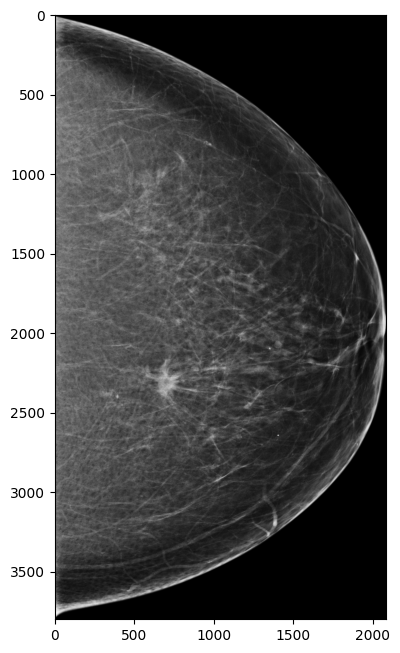

(3801, 2085, 3)


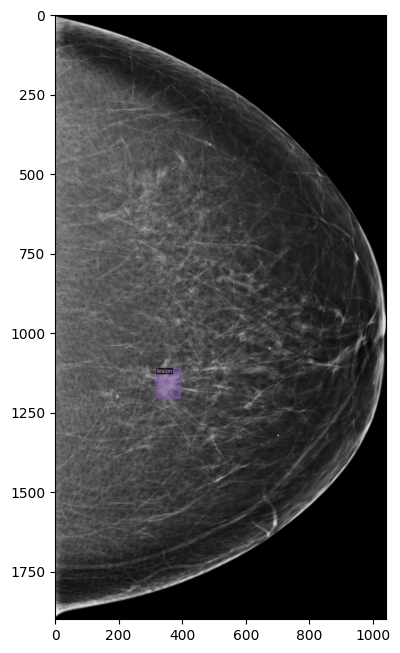

/mnt/mia_images/breast/omi-db/iceberg_selection/HOLOGIC/ffdm/st110/demd3035_9988_1.2.826.0.1.3680043.9.3218.1.1.1405750.1758.1511969095974.1815.0_CC.png


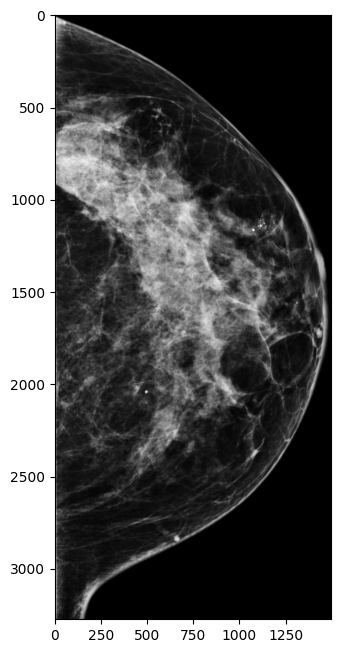

(3274, 1496, 3)


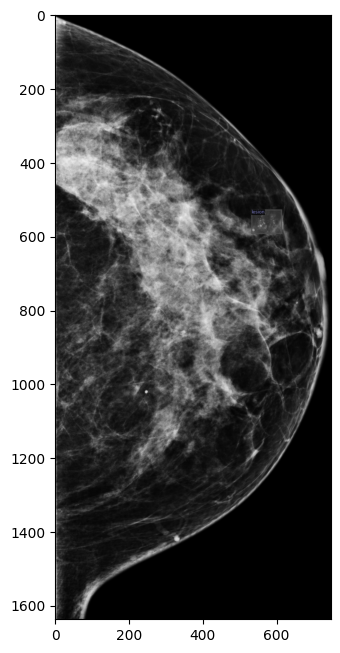

/mnt/mia_images/breast/omi-db/iceberg_selection/HOLOGIC/ffdm/st111/demd949_9978_1.2.826.0.1.3680043.9.3218.1.1.2817686.8536.1510351239985.7633.0_CC.png


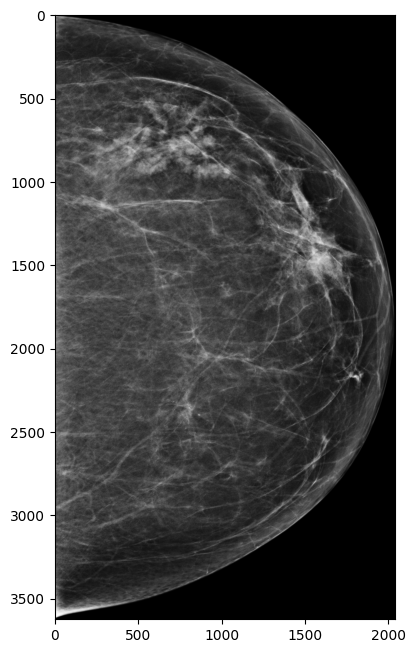

(3623, 2038, 3)


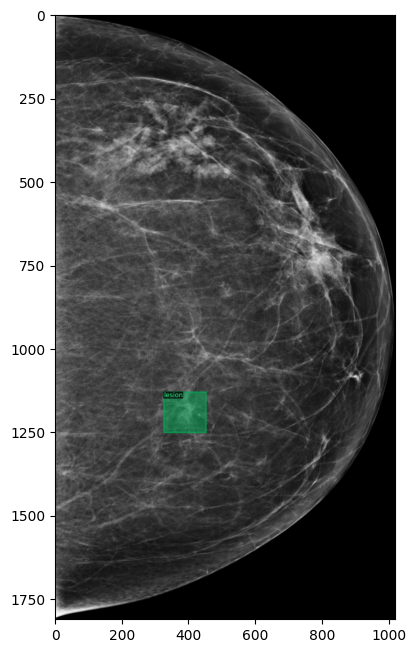

In [9]:
for d in random.sample(dataset_dicts, 3):
    print (d["file_name"])
    img = cv2.imread(d["file_name"])
    plt.imshow(img)
    plt.show()
    print((img.shape))
    visualizer = Visualizer(img[:, :, ::-1], metadata=omidb_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()

## Train with omidb

In [10]:
from detectron2.engine import DefaultTrainer

model_file = "./model/faster_rcnn_R2_101_FPN_3x.yaml"
omidb_model_file = "model_final_R2_101_omidb_10k.pth"
dbt_model_file = "model_final_R2_101_omidb_10k_dbt.pth"
config_file = "config_trained_R2_101_10k.yaml"


In [10]:
# example based on detectorn 2 notebook,
# https://detectron2.readthedocs.io/en/latest/tutorials/datasets.html
cfg = get_cfg()
#  Trying res2net.
cfg.merge_from_file(model_file)

# model downloaded from https://github.com/Res2Net/Res2Net-detectron2
cfg.MODEL.WEIGHTS = "./model/r2_101.pkl"

cfg.DATASETS.TRAIN = ("omidb_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
# RM NOT LOADING WITH PRE-TRAINING
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 10000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

# Save config to file
with open("output/"+config_file, "w") as f:
    f.write(cfg.dump())

[01/20 01:41:46 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Sequential(
          (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): FrozenBatchNorm2d(num_features=32, eps=1e-05)
          (2):

[01/20 01:41:49 d2.data.build]: Removed 0 images with no usable annotations. 3614 images left.
[01/20 01:41:49 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   lesion   | 3614         |
|            |              |
[01/20 01:41:49 d2.data.common]: Serializing 3614 elements to byte tensors and concatenating them all ...
[01/20 01:41:49 d2.data.common]: Serialized dataset takes 2.52 MiB
[01/20 01:41:49 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[01/20 01:41:49 d2.data.build]: Using training sampler TrainingSampler
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res2.0.bns.0.bias                   loaded from res2.0.bns.0.bias                          of shape (26,)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res2.0.bns.0.running

[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res2.1.bns.2.weight                 loaded from res2.1.bns.2.weight                        of shape (26,)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res2.1.conv1.norm.bias              loaded from res2.1.conv1.norm.bias                     of shape (104,)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res2.1.conv1.norm.running_mean      loaded from res2.1.conv1.norm.running_mean             of shape (104,)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res2.1.conv1.norm.running_var       loaded from res2.1.conv1.norm.running_var              of shape (104,)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res2.1.conv1.norm.weight            loaded from res2.1.conv1.norm.weight                   of shape (104,)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res2.1.conv1.weight                 loaded from res2.1.con

[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res3.0.bns.1.running_var            loaded from res3.0.bns.1.running_var                   of shape (52,)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res3.0.bns.1.weight                 loaded from res3.0.bns.1.weight                        of shape (52,)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res3.0.bns.2.bias                   loaded from res3.0.bns.2.bias                          of shape (52,)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res3.0.bns.2.running_mean           loaded from res3.0.bns.2.running_mean                  of shape (52,)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res3.0.bns.2.running_var            loaded from res3.0.bns.2.running_var                   of shape (52,)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res3.0.bns.2.weight                 loaded from res3.0.bns.2.w

[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res3.1.conv3.weight                 loaded from res3.1.conv3.weight                        of shape (512, 208, 1, 1)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res3.1.convs.0.weight               loaded from res3.1.convs.0.weight                      of shape (52, 52, 3, 3)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res3.1.convs.1.weight               loaded from res3.1.convs.1.weight                      of shape (52, 52, 3, 3)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res3.1.convs.2.weight               loaded from res3.1.convs.2.weight                      of shape (52, 52, 3, 3)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res3.2.bns.0.bias                   loaded from res3.2.bns.0.bias                          of shape (52,)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res3.2.bns.0.running_mea

[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res3.3.conv1.weight                 loaded from res3.3.conv1.weight                        of shape (208, 512, 1, 1)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res3.3.conv3.norm.bias              loaded from res3.3.conv3.norm.bias                     of shape (512,)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res3.3.conv3.norm.running_mean      loaded from res3.3.conv3.norm.running_mean             of shape (512,)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res3.3.conv3.norm.running_var       loaded from res3.3.conv3.norm.running_var              of shape (512,)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res3.3.conv3.norm.weight            loaded from res3.3.conv3.norm.weight                   of shape (512,)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res3.3.conv3.weight                 loaded from

[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.1.bns.1.running_mean           loaded from res4.1.bns.1.running_mean                  of shape (104,)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.1.bns.1.running_var            loaded from res4.1.bns.1.running_var                   of shape (104,)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.1.bns.1.weight                 loaded from res4.1.bns.1.weight                        of shape (104,)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.1.bns.2.bias                   loaded from res4.1.bns.2.bias                          of shape (104,)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.1.bns.2.running_mean           loaded from res4.1.bns.2.running_mean                  of shape (104,)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.1.bns.2.running_var            loaded from res4.1.bn

[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.10.convs.2.weight              loaded from res4.10.convs.2.weight                     of shape (104, 104, 3, 3)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.11.bns.0.bias                  loaded from res4.11.bns.0.bias                         of shape (104,)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.11.bns.0.running_mean          loaded from res4.11.bns.0.running_mean                 of shape (104,)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.11.bns.0.running_var           loaded from res4.11.bns.0.running_var                  of shape (104,)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.11.bns.0.weight                loaded from res4.11.bns.0.weight                       of shape (104,)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.11.bns.1.bias                  loaded from

[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.12.conv3.norm.running_var      loaded from res4.12.conv3.norm.running_var             of shape (1024,)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.12.conv3.norm.weight           loaded from res4.12.conv3.norm.weight                  of shape (1024,)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.12.conv3.weight                loaded from res4.12.conv3.weight                       of shape (1024, 416, 1, 1)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.12.convs.0.weight              loaded from res4.12.convs.0.weight                     of shape (104, 104, 3, 3)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.12.convs.1.weight              loaded from res4.12.convs.1.weight                     of shape (104, 104, 3, 3)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.12.convs.2.weight  

[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.14.conv1.norm.running_mean     loaded from res4.14.conv1.norm.running_mean            of shape (416,)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.14.conv1.norm.running_var      loaded from res4.14.conv1.norm.running_var             of shape (416,)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.14.conv1.norm.weight           loaded from res4.14.conv1.norm.weight                  of shape (416,)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.14.conv1.weight                loaded from res4.14.conv1.weight                       of shape (416, 1024, 1, 1)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.14.conv3.norm.bias             loaded from res4.14.conv3.norm.bias                    of shape (1024,)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.14.conv3.norm.running_mean     loaded fr

[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.16.bns.1.weight                loaded from res4.16.bns.1.weight                       of shape (104,)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.16.bns.2.bias                  loaded from res4.16.bns.2.bias                         of shape (104,)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.16.bns.2.running_mean          loaded from res4.16.bns.2.running_mean                 of shape (104,)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.16.bns.2.running_var           loaded from res4.16.bns.2.running_var                  of shape (104,)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.16.bns.2.weight                loaded from res4.16.bns.2.weight                       of shape (104,)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.16.conv1.norm.bias             loaded from res4.16.c

[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.18.bns.0.running_mean          loaded from res4.18.bns.0.running_mean                 of shape (104,)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.18.bns.0.running_var           loaded from res4.18.bns.0.running_var                  of shape (104,)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.18.bns.0.weight                loaded from res4.18.bns.0.weight                       of shape (104,)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.18.bns.1.bias                  loaded from res4.18.bns.1.bias                         of shape (104,)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.18.bns.1.running_mean          loaded from res4.18.bns.1.running_mean                 of shape (104,)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.18.bns.1.running_var           loaded from res4.18.b

[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.19.conv3.weight                loaded from res4.19.conv3.weight                       of shape (1024, 416, 1, 1)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.19.convs.0.weight              loaded from res4.19.convs.0.weight                     of shape (104, 104, 3, 3)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.19.convs.1.weight              loaded from res4.19.convs.1.weight                     of shape (104, 104, 3, 3)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.19.convs.2.weight              loaded from res4.19.convs.2.weight                     of shape (104, 104, 3, 3)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.2.bns.0.bias                   loaded from res4.2.bns.0.bias                          of shape (104,)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.2.bns.0.run

[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.20.conv1.norm.weight           loaded from res4.20.conv1.norm.weight                  of shape (416,)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.20.conv1.weight                loaded from res4.20.conv1.weight                       of shape (416, 1024, 1, 1)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.20.conv3.norm.bias             loaded from res4.20.conv3.norm.bias                    of shape (1024,)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.20.conv3.norm.running_mean     loaded from res4.20.conv3.norm.running_mean            of shape (1024,)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.20.conv3.norm.running_var      loaded from res4.20.conv3.norm.running_var             of shape (1024,)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.20.conv3.norm.weight           loaded 

[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.22.bns.2.running_mean          loaded from res4.22.bns.2.running_mean                 of shape (104,)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.22.bns.2.running_var           loaded from res4.22.bns.2.running_var                  of shape (104,)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.22.bns.2.weight                loaded from res4.22.bns.2.weight                       of shape (104,)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.22.conv1.norm.bias             loaded from res4.22.conv1.norm.bias                    of shape (416,)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.22.conv1.norm.running_mean     loaded from res4.22.conv1.norm.running_mean            of shape (416,)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.22.conv1.norm.running_var      loaded from res4.22.c

[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.4.bns.0.weight                 loaded from res4.4.bns.0.weight                        of shape (104,)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.4.bns.1.bias                   loaded from res4.4.bns.1.bias                          of shape (104,)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.4.bns.1.running_mean           loaded from res4.4.bns.1.running_mean                  of shape (104,)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.4.bns.1.running_var            loaded from res4.4.bns.1.running_var                   of shape (104,)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.4.bns.1.weight                 loaded from res4.4.bns.1.weight                        of shape (104,)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.4.bns.2.bias                   loaded from res4.4.bn

[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.5.convs.1.weight               loaded from res4.5.convs.1.weight                      of shape (104, 104, 3, 3)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.5.convs.2.weight               loaded from res4.5.convs.2.weight                      of shape (104, 104, 3, 3)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.6.bns.0.bias                   loaded from res4.6.bns.0.bias                          of shape (104,)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.6.bns.0.running_mean           loaded from res4.6.bns.0.running_mean                  of shape (104,)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.6.bns.0.running_var            loaded from res4.6.bns.0.running_var                   of shape (104,)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.6.bns.0.weight                 l

[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.7.conv3.norm.running_mean      loaded from res4.7.conv3.norm.running_mean             of shape (1024,)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.7.conv3.norm.running_var       loaded from res4.7.conv3.norm.running_var              of shape (1024,)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.7.conv3.norm.weight            loaded from res4.7.conv3.norm.weight                   of shape (1024,)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.7.conv3.weight                 loaded from res4.7.conv3.weight                        of shape (1024, 416, 1, 1)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.7.convs.0.weight               loaded from res4.7.convs.0.weight                      of shape (104, 104, 3, 3)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.7.convs.1.weight            

[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.9.conv1.norm.bias              loaded from res4.9.conv1.norm.bias                     of shape (416,)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.9.conv1.norm.running_mean      loaded from res4.9.conv1.norm.running_mean             of shape (416,)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.9.conv1.norm.running_var       loaded from res4.9.conv1.norm.running_var              of shape (416,)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.9.conv1.norm.weight            loaded from res4.9.conv1.norm.weight                   of shape (416,)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.9.conv1.weight                 loaded from res4.9.conv1.weight                        of shape (416, 1024, 1, 1)
[01/20 01:41:50 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.9.conv3.norm.bias              loaded fro

[01/20 01:41:51 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res5.1.bns.0.running_mean           loaded from res5.1.bns.0.running_mean                  of shape (208,)
[01/20 01:41:51 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res5.1.bns.0.running_var            loaded from res5.1.bns.0.running_var                   of shape (208,)
[01/20 01:41:51 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res5.1.bns.0.weight                 loaded from res5.1.bns.0.weight                        of shape (208,)
[01/20 01:41:51 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res5.1.bns.1.bias                   loaded from res5.1.bns.1.bias                          of shape (208,)
[01/20 01:41:51 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res5.1.bns.1.running_mean           loaded from res5.1.bns.1.running_mean                  of shape (208,)
[01/20 01:41:51 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res5.1.bns.1.running_var            loaded from res5.1.bn

[01/20 01:41:51 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res5.2.conv3.weight                 loaded from res5.2.conv3.weight                        of shape (2048, 832, 1, 1)
[01/20 01:41:51 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res5.2.convs.0.weight               loaded from res5.2.convs.0.weight                      of shape (208, 208, 3, 3)
[01/20 01:41:51 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res5.2.convs.1.weight               loaded from res5.2.convs.1.weight                      of shape (208, 208, 3, 3)
[01/20 01:41:51 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res5.2.convs.2.weight               loaded from res5.2.convs.2.weight                      of shape (208, 208, 3, 3)
[01/20 01:41:51 d2.checkpoint.c2_model_loading]: backbone.bottom_up.stem.bn1.bias                       loaded from stem.bn1.bias                              of shape (64,)
[01/20 01:41:51 d2.checkpoint.c2_model_loading]: backbone.bottom_up.stem.bn1.running_

[01/20 01:41:51 d2.engine.train_loop]: Starting training from iteration 0


/home/robert/src/detectron2/Res2Net-detectron2/detectron2/modeling/roi_heads/fast_rcnn.py:199: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  num_fg = fg_inds.nonzero().numel()


[01/20 01:42:08 d2.utils.events]:  eta: 1:33:22  iter: 19  total_loss: 1.322  loss_cls: 0.625  loss_box_reg: 0.000  loss_rpn_cls: 0.688  loss_rpn_loc: 0.008  time: 0.5621  data_time: 0.5266  lr: 0.000005  max_mem: 4859M
[01/20 01:42:19 d2.utils.events]:  eta: 1:28:37  iter: 39  total_loss: 1.207  loss_cls: 0.500  loss_box_reg: 0.000  loss_rpn_cls: 0.687  loss_rpn_loc: 0.007  time: 0.5411  data_time: 0.1910  lr: 0.000010  max_mem: 4859M
[01/20 01:42:30 d2.utils.events]:  eta: 1:28:07  iter: 59  total_loss: 0.989  loss_cls: 0.279  loss_box_reg: 0.010  loss_rpn_cls: 0.682  loss_rpn_loc: 0.006  time: 0.5439  data_time: 0.2114  lr: 0.000015  max_mem: 4859M
[01/20 01:42:40 d2.utils.events]:  eta: 1:23:50  iter: 79  total_loss: 0.900  loss_cls: 0.205  loss_box_reg: 0.010  loss_rpn_cls: 0.669  loss_rpn_loc: 0.010  time: 0.5325  data_time: 0.1591  lr: 0.000020  max_mem: 4859M
[01/20 01:42:52 d2.utils.events]:  eta: 1:25:10  iter: 99  total_loss: 0.766  loss_cls: 0.098  loss_box_reg: 0.016  loss

[01/20 01:49:51 d2.utils.events]:  eta: 1:20:25  iter: 739  total_loss: 0.224  loss_cls: 0.097  loss_box_reg: 0.087  loss_rpn_cls: 0.040  loss_rpn_loc: 0.009  time: 0.6374  data_time: 0.1874  lr: 0.000185  max_mem: 4859M
[01/20 01:50:01 d2.utils.events]:  eta: 1:20:06  iter: 759  total_loss: 0.220  loss_cls: 0.092  loss_box_reg: 0.085  loss_rpn_cls: 0.029  loss_rpn_loc: 0.008  time: 0.6338  data_time: 0.1680  lr: 0.000190  max_mem: 4859M
[01/20 01:50:15 d2.utils.events]:  eta: 1:20:02  iter: 779  total_loss: 0.229  loss_cls: 0.091  loss_box_reg: 0.091  loss_rpn_cls: 0.032  loss_rpn_loc: 0.007  time: 0.6353  data_time: 0.3536  lr: 0.000195  max_mem: 4859M
[01/20 01:50:26 d2.utils.events]:  eta: 1:19:49  iter: 799  total_loss: 0.216  loss_cls: 0.086  loss_box_reg: 0.086  loss_rpn_cls: 0.026  loss_rpn_loc: 0.007  time: 0.6329  data_time: 0.2001  lr: 0.000200  max_mem: 4859M
[01/20 01:50:36 d2.utils.events]:  eta: 1:19:35  iter: 819  total_loss: 0.195  loss_cls: 0.073  loss_box_reg: 0.056 

[01/20 01:57:25 d2.utils.events]:  eta: 1:10:53  iter: 1459  total_loss: 0.206  loss_cls: 0.082  loss_box_reg: 0.076  loss_rpn_cls: 0.028  loss_rpn_loc: 0.008  time: 0.6318  data_time: 0.1920  lr: 0.000250  max_mem: 4859M
[01/20 01:57:42 d2.utils.events]:  eta: 1:11:20  iter: 1479  total_loss: 0.207  loss_cls: 0.089  loss_box_reg: 0.088  loss_rpn_cls: 0.024  loss_rpn_loc: 0.007  time: 0.6345  data_time: 0.4870  lr: 0.000250  max_mem: 4859M
[01/20 01:57:55 d2.utils.events]:  eta: 1:10:45  iter: 1499  total_loss: 0.171  loss_cls: 0.074  loss_box_reg: 0.077  loss_rpn_cls: 0.018  loss_rpn_loc: 0.006  time: 0.6349  data_time: 0.3094  lr: 0.000250  max_mem: 4859M
[01/20 01:58:07 d2.utils.events]:  eta: 1:10:52  iter: 1519  total_loss: 0.172  loss_cls: 0.070  loss_box_reg: 0.073  loss_rpn_cls: 0.018  loss_rpn_loc: 0.006  time: 0.6344  data_time: 0.2465  lr: 0.000250  max_mem: 4859M
[01/20 01:58:17 d2.utils.events]:  eta: 1:10:25  iter: 1539  total_loss: 0.176  loss_cls: 0.080  loss_box_reg: 0

[01/20 02:05:05 d2.utils.events]:  eta: 1:04:54  iter: 2179  total_loss: 0.184  loss_cls: 0.082  loss_box_reg: 0.084  loss_rpn_cls: 0.018  loss_rpn_loc: 0.006  time: 0.6326  data_time: 0.1658  lr: 0.000250  max_mem: 4859M
[01/20 02:05:16 d2.utils.events]:  eta: 1:04:27  iter: 2199  total_loss: 0.201  loss_cls: 0.094  loss_box_reg: 0.091  loss_rpn_cls: 0.015  loss_rpn_loc: 0.007  time: 0.6318  data_time: 0.1951  lr: 0.000250  max_mem: 4859M
[01/20 02:05:30 d2.utils.events]:  eta: 1:04:00  iter: 2219  total_loss: 0.173  loss_cls: 0.071  loss_box_reg: 0.077  loss_rpn_cls: 0.010  loss_rpn_loc: 0.006  time: 0.6323  data_time: 0.3295  lr: 0.000250  max_mem: 4859M
[01/20 02:05:44 d2.utils.events]:  eta: 1:03:46  iter: 2239  total_loss: 0.188  loss_cls: 0.085  loss_box_reg: 0.080  loss_rpn_cls: 0.017  loss_rpn_loc: 0.007  time: 0.6328  data_time: 0.3484  lr: 0.000250  max_mem: 4859M
[01/20 02:05:54 d2.utils.events]:  eta: 1:03:29  iter: 2259  total_loss: 0.184  loss_cls: 0.081  loss_box_reg: 0

[01/20 02:12:45 d2.utils.events]:  eta: 0:58:43  iter: 2899  total_loss: 0.196  loss_cls: 0.077  loss_box_reg: 0.088  loss_rpn_cls: 0.019  loss_rpn_loc: 0.008  time: 0.6333  data_time: 0.6178  lr: 0.000250  max_mem: 4859M
[01/20 02:12:57 d2.utils.events]:  eta: 0:58:46  iter: 2919  total_loss: 0.211  loss_cls: 0.084  loss_box_reg: 0.088  loss_rpn_cls: 0.011  loss_rpn_loc: 0.007  time: 0.6331  data_time: 0.2759  lr: 0.000250  max_mem: 4859M
[01/20 02:13:07 d2.utils.events]:  eta: 0:58:41  iter: 2939  total_loss: 0.202  loss_cls: 0.090  loss_box_reg: 0.094  loss_rpn_cls: 0.013  loss_rpn_loc: 0.007  time: 0.6321  data_time: 0.1350  lr: 0.000250  max_mem: 4859M
[01/20 02:13:18 d2.utils.events]:  eta: 0:58:31  iter: 2959  total_loss: 0.196  loss_cls: 0.087  loss_box_reg: 0.085  loss_rpn_cls: 0.013  loss_rpn_loc: 0.005  time: 0.6315  data_time: 0.2115  lr: 0.000250  max_mem: 4859M
[01/20 02:13:36 d2.utils.events]:  eta: 0:58:25  iter: 2979  total_loss: 0.195  loss_cls: 0.077  loss_box_reg: 0

[01/20 02:20:47 d2.utils.events]:  eta: 0:53:16  iter: 3619  total_loss: 0.194  loss_cls: 0.089  loss_box_reg: 0.084  loss_rpn_cls: 0.015  loss_rpn_loc: 0.006  time: 0.6397  data_time: 0.1598  lr: 0.000250  max_mem: 4859M
[01/20 02:20:58 d2.utils.events]:  eta: 0:52:55  iter: 3639  total_loss: 0.203  loss_cls: 0.090  loss_box_reg: 0.090  loss_rpn_cls: 0.011  loss_rpn_loc: 0.006  time: 0.6392  data_time: 0.2044  lr: 0.000250  max_mem: 4859M
[01/20 02:21:11 d2.utils.events]:  eta: 0:53:15  iter: 3659  total_loss: 0.198  loss_cls: 0.079  loss_box_reg: 0.089  loss_rpn_cls: 0.015  loss_rpn_loc: 0.006  time: 0.6390  data_time: 0.2661  lr: 0.000250  max_mem: 4859M
[01/20 02:21:21 d2.utils.events]:  eta: 0:52:58  iter: 3679  total_loss: 0.196  loss_cls: 0.080  loss_box_reg: 0.094  loss_rpn_cls: 0.010  loss_rpn_loc: 0.005  time: 0.6385  data_time: 0.1923  lr: 0.000250  max_mem: 4859M
[01/20 02:21:33 d2.utils.events]:  eta: 0:52:48  iter: 3699  total_loss: 0.188  loss_cls: 0.080  loss_box_reg: 0

[01/20 02:28:21 d2.utils.events]:  eta: 0:47:33  iter: 4339  total_loss: 0.219  loss_cls: 0.083  loss_box_reg: 0.087  loss_rpn_cls: 0.013  loss_rpn_loc: 0.007  time: 0.6373  data_time: 0.1640  lr: 0.000250  max_mem: 4859M
[01/20 02:28:31 d2.utils.events]:  eta: 0:47:24  iter: 4359  total_loss: 0.205  loss_cls: 0.074  loss_box_reg: 0.097  loss_rpn_cls: 0.013  loss_rpn_loc: 0.007  time: 0.6369  data_time: 0.1907  lr: 0.000250  max_mem: 4859M
[01/20 02:28:42 d2.utils.events]:  eta: 0:47:09  iter: 4379  total_loss: 0.198  loss_cls: 0.080  loss_box_reg: 0.103  loss_rpn_cls: 0.008  loss_rpn_loc: 0.007  time: 0.6364  data_time: 0.1916  lr: 0.000250  max_mem: 4859M
[01/20 02:29:01 d2.utils.events]:  eta: 0:46:58  iter: 4399  total_loss: 0.197  loss_cls: 0.085  loss_box_reg: 0.095  loss_rpn_cls: 0.008  loss_rpn_loc: 0.006  time: 0.6378  data_time: 0.5941  lr: 0.000250  max_mem: 4859M
[01/20 02:29:11 d2.utils.events]:  eta: 0:46:49  iter: 4419  total_loss: 0.189  loss_cls: 0.086  loss_box_reg: 0

[01/20 02:36:09 d2.utils.events]:  eta: 0:41:21  iter: 5059  total_loss: 0.201  loss_cls: 0.089  loss_box_reg: 0.090  loss_rpn_cls: 0.009  loss_rpn_loc: 0.007  time: 0.6377  data_time: 0.2207  lr: 0.000250  max_mem: 4859M
[01/20 02:36:30 d2.utils.events]:  eta: 0:41:15  iter: 5079  total_loss: 0.207  loss_cls: 0.079  loss_box_reg: 0.102  loss_rpn_cls: 0.009  loss_rpn_loc: 0.006  time: 0.6392  data_time: 0.6685  lr: 0.000250  max_mem: 4859M
[01/20 02:36:41 d2.utils.events]:  eta: 0:41:01  iter: 5099  total_loss: 0.203  loss_cls: 0.091  loss_box_reg: 0.081  loss_rpn_cls: 0.009  loss_rpn_loc: 0.007  time: 0.6388  data_time: 0.1870  lr: 0.000250  max_mem: 4859M
[01/20 02:36:50 d2.utils.events]:  eta: 0:40:49  iter: 5119  total_loss: 0.207  loss_cls: 0.083  loss_box_reg: 0.107  loss_rpn_cls: 0.011  loss_rpn_loc: 0.007  time: 0.6382  data_time: 0.1451  lr: 0.000250  max_mem: 4859M
[01/20 02:37:05 d2.utils.events]:  eta: 0:40:38  iter: 5139  total_loss: 0.191  loss_cls: 0.080  loss_box_reg: 0

[01/20 02:44:05 d2.utils.events]:  eta: 0:35:37  iter: 5779  total_loss: 0.182  loss_cls: 0.074  loss_box_reg: 0.084  loss_rpn_cls: 0.012  loss_rpn_loc: 0.006  time: 0.6401  data_time: 0.1668  lr: 0.000250  max_mem: 4859M
[01/20 02:44:16 d2.utils.events]:  eta: 0:35:19  iter: 5799  total_loss: 0.195  loss_cls: 0.080  loss_box_reg: 0.098  loss_rpn_cls: 0.007  loss_rpn_loc: 0.006  time: 0.6397  data_time: 0.1984  lr: 0.000250  max_mem: 4859M
[01/20 02:44:34 d2.utils.events]:  eta: 0:35:09  iter: 5819  total_loss: 0.193  loss_cls: 0.079  loss_box_reg: 0.103  loss_rpn_cls: 0.005  loss_rpn_loc: 0.006  time: 0.6406  data_time: 0.5585  lr: 0.000250  max_mem: 4859M
[01/20 02:44:45 d2.utils.events]:  eta: 0:34:58  iter: 5839  total_loss: 0.216  loss_cls: 0.093  loss_box_reg: 0.100  loss_rpn_cls: 0.008  loss_rpn_loc: 0.005  time: 0.6402  data_time: 0.1688  lr: 0.000250  max_mem: 4859M
[01/20 02:44:55 d2.utils.events]:  eta: 0:34:48  iter: 5859  total_loss: 0.223  loss_cls: 0.092  loss_box_reg: 0

[01/20 02:51:41 d2.utils.events]:  eta: 0:29:21  iter: 6499  total_loss: 0.230  loss_cls: 0.096  loss_box_reg: 0.112  loss_rpn_cls: 0.009  loss_rpn_loc: 0.005  time: 0.6388  data_time: 0.1982  lr: 0.000250  max_mem: 4859M
[01/20 02:51:55 d2.utils.events]:  eta: 0:29:10  iter: 6519  total_loss: 0.217  loss_cls: 0.092  loss_box_reg: 0.107  loss_rpn_cls: 0.006  loss_rpn_loc: 0.007  time: 0.6390  data_time: 0.3336  lr: 0.000250  max_mem: 4859M
[01/20 02:52:04 d2.utils.events]:  eta: 0:28:55  iter: 6539  total_loss: 0.194  loss_cls: 0.074  loss_box_reg: 0.104  loss_rpn_cls: 0.005  loss_rpn_loc: 0.005  time: 0.6385  data_time: 0.1371  lr: 0.000250  max_mem: 4859M
[01/20 02:52:14 d2.utils.events]:  eta: 0:28:38  iter: 6559  total_loss: 0.210  loss_cls: 0.082  loss_box_reg: 0.101  loss_rpn_cls: 0.008  loss_rpn_loc: 0.007  time: 0.6380  data_time: 0.1353  lr: 0.000250  max_mem: 4859M
[01/20 02:52:26 d2.utils.events]:  eta: 0:28:28  iter: 6579  total_loss: 0.211  loss_cls: 0.092  loss_box_reg: 0

[01/20 02:58:49 d2.utils.events]:  eta: 0:22:57  iter: 7219  total_loss: 0.180  loss_cls: 0.071  loss_box_reg: 0.091  loss_rpn_cls: 0.005  loss_rpn_loc: 0.006  time: 0.6340  data_time: 0.1294  lr: 0.000250  max_mem: 4859M
[01/20 02:59:10 d2.utils.events]:  eta: 0:22:48  iter: 7239  total_loss: 0.197  loss_cls: 0.079  loss_box_reg: 0.106  loss_rpn_cls: 0.006  loss_rpn_loc: 0.006  time: 0.6351  data_time: 0.6948  lr: 0.000250  max_mem: 4859M
[01/20 02:59:20 d2.utils.events]:  eta: 0:22:27  iter: 7259  total_loss: 0.204  loss_cls: 0.083  loss_box_reg: 0.101  loss_rpn_cls: 0.008  loss_rpn_loc: 0.006  time: 0.6347  data_time: 0.1330  lr: 0.000250  max_mem: 4859M
[01/20 02:59:30 d2.utils.events]:  eta: 0:22:19  iter: 7279  total_loss: 0.180  loss_cls: 0.079  loss_box_reg: 0.089  loss_rpn_cls: 0.010  loss_rpn_loc: 0.007  time: 0.6344  data_time: 0.1780  lr: 0.000250  max_mem: 4859M
[01/20 02:59:40 d2.utils.events]:  eta: 0:22:07  iter: 7299  total_loss: 0.185  loss_cls: 0.075  loss_box_reg: 0

[01/20 03:06:49 d2.utils.events]:  eta: 0:17:18  iter: 7939  total_loss: 0.200  loss_cls: 0.083  loss_box_reg: 0.084  loss_rpn_cls: 0.004  loss_rpn_loc: 0.005  time: 0.6366  data_time: 0.4258  lr: 0.000250  max_mem: 4859M
[01/20 03:07:00 d2.utils.events]:  eta: 0:17:08  iter: 7959  total_loss: 0.189  loss_cls: 0.080  loss_box_reg: 0.090  loss_rpn_cls: 0.009  loss_rpn_loc: 0.005  time: 0.6364  data_time: 0.2020  lr: 0.000250  max_mem: 4859M
[01/20 03:07:10 d2.utils.events]:  eta: 0:16:53  iter: 7979  total_loss: 0.196  loss_cls: 0.081  loss_box_reg: 0.101  loss_rpn_cls: 0.008  loss_rpn_loc: 0.006  time: 0.6360  data_time: 0.1648  lr: 0.000250  max_mem: 4859M
[01/20 03:07:23 d2.utils.events]:  eta: 0:16:42  iter: 7999  total_loss: 0.200  loss_cls: 0.089  loss_box_reg: 0.097  loss_rpn_cls: 0.007  loss_rpn_loc: 0.005  time: 0.6360  data_time: 0.2744  lr: 0.000250  max_mem: 4859M
[01/20 03:07:32 d2.utils.events]:  eta: 0:16:32  iter: 8019  total_loss: 0.210  loss_cls: 0.085  loss_box_reg: 0

[01/20 03:14:32 d2.utils.events]:  eta: 0:11:22  iter: 8659  total_loss: 0.201  loss_cls: 0.078  loss_box_reg: 0.105  loss_rpn_cls: 0.004  loss_rpn_loc: 0.005  time: 0.6367  data_time: 0.5427  lr: 0.000250  max_mem: 4859M
[01/20 03:14:43 d2.utils.events]:  eta: 0:11:11  iter: 8679  total_loss: 0.191  loss_cls: 0.076  loss_box_reg: 0.085  loss_rpn_cls: 0.006  loss_rpn_loc: 0.005  time: 0.6365  data_time: 0.1923  lr: 0.000250  max_mem: 4859M
[01/20 03:14:52 d2.utils.events]:  eta: 0:11:00  iter: 8699  total_loss: 0.209  loss_cls: 0.089  loss_box_reg: 0.103  loss_rpn_cls: 0.005  loss_rpn_loc: 0.005  time: 0.6361  data_time: 0.1300  lr: 0.000250  max_mem: 4859M
[01/20 03:15:02 d2.utils.events]:  eta: 0:10:50  iter: 8719  total_loss: 0.212  loss_cls: 0.086  loss_box_reg: 0.103  loss_rpn_cls: 0.005  loss_rpn_loc: 0.006  time: 0.6358  data_time: 0.1618  lr: 0.000250  max_mem: 4859M
[01/20 03:15:19 d2.utils.events]:  eta: 0:10:40  iter: 8739  total_loss: 0.201  loss_cls: 0.089  loss_box_reg: 0

[01/20 03:22:17 d2.utils.events]:  eta: 0:05:08  iter: 9379  total_loss: 0.202  loss_cls: 0.085  loss_box_reg: 0.099  loss_rpn_cls: 0.006  loss_rpn_loc: 0.006  time: 0.6371  data_time: 0.1600  lr: 0.000250  max_mem: 4859M
[01/20 03:22:32 d2.utils.events]:  eta: 0:04:58  iter: 9399  total_loss: 0.201  loss_cls: 0.075  loss_box_reg: 0.105  loss_rpn_cls: 0.006  loss_rpn_loc: 0.006  time: 0.6374  data_time: 0.4232  lr: 0.000250  max_mem: 4859M
[01/20 03:22:43 d2.utils.events]:  eta: 0:04:48  iter: 9419  total_loss: 0.187  loss_cls: 0.080  loss_box_reg: 0.083  loss_rpn_cls: 0.005  loss_rpn_loc: 0.005  time: 0.6371  data_time: 0.1842  lr: 0.000250  max_mem: 4859M
[01/20 03:22:53 d2.utils.events]:  eta: 0:04:38  iter: 9439  total_loss: 0.186  loss_cls: 0.072  loss_box_reg: 0.091  loss_rpn_cls: 0.008  loss_rpn_loc: 0.007  time: 0.6369  data_time: 0.1860  lr: 0.000250  max_mem: 4859M
[01/20 03:23:04 d2.utils.events]:  eta: 0:04:28  iter: 9459  total_loss: 0.204  loss_cls: 0.087  loss_box_reg: 0

In [11]:
import os
os.rename(r'./output/model_final.pth',r'./output/'+omidb_model_file)


In [12]:
import os
PATH = os.getenv('PATH')
%env PATH=/home/robert/miniconda2/envs/fast2/bin:$PATH
%load_ext tensorboard
%tensorboard --logdir output --host localhost --port 8885


env: PATH=/home/robert/miniconda2/envs/fast2/bin:/home/robert/bin:/home/robert/.local/bin:/usr/local/cuda/bin:/home/robert/bin:/home/robert/.local/bin:/home/robert/miniconda2/bin:/home/robert/miniconda2/condabin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin


Reusing TensorBoard on port 8885 (pid 37385), started 3 days, 2:25:27 ago. (Use '!kill 37385' to kill it.)

### Test: Individual prediction with omidb


/mnt/mia_images/breast/omi-db/iceberg_selection/HOLOGIC/ffdm/st110/demd41518_9982_1.2.826.0.1.3680043.9.3218.1.1.27604652.1234.1536063822667.110.0_CC.png
{'instances': Instances(num_instances=3, image_height=3189, image_width=1453, fields=[pred_boxes: Boxes(tensor([[ 289.3828,  936.0485,  498.8308, 1118.9644],
        [ 247.6233,  896.2922,  574.4832, 1149.6261],
        [1019.6284, 1526.5974, 1127.5238, 1627.8043]], device='cuda:0')), scores: tensor([0.9209, 0.3140, 0.2506], device='cuda:0'), pred_classes: tensor([0, 0, 0], device='cuda:0')])}
tensor([0, 0, 0])
Boxes(tensor([[ 289.3828,  936.0485,  498.8308, 1118.9644],
        [ 247.6233,  896.2922,  574.4832, 1149.6261],
        [1019.6284, 1526.5974, 1127.5238, 1627.8043]]))
tensor([0.9209, 0.3140, 0.2506])


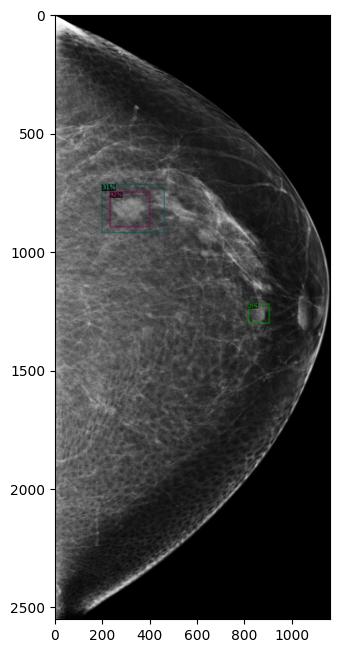

/mnt/mia_images/breast/omi-db/iceberg_selection/HOLOGIC/ffdm/st110/demd3557_9973_1.2.826.0.1.3680043.9.3218.1.1.1478478.5024.1511976368784.7291.0_CC.png
{'instances': Instances(num_instances=2, image_height=2855, image_width=1149, fields=[pred_boxes: Boxes(tensor([[ 496.6202, 1788.7972,  746.5173, 2009.1169],
        [ 456.0125, 1682.5422,  791.3622, 2053.0911]], device='cuda:0')), scores: tensor([0.8746, 0.2863], device='cuda:0'), pred_classes: tensor([0, 0], device='cuda:0')])}
tensor([0, 0])
Boxes(tensor([[ 496.6202, 1788.7972,  746.5173, 2009.1169],
        [ 456.0125, 1682.5422,  791.3622, 2053.0911]]))
tensor([0.8746, 0.2863])


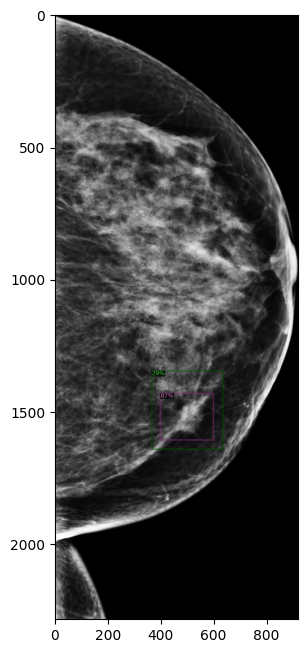

/mnt/mia_images/breast/omi-db/iceberg_selection/HOLOGIC/ffdm/st110/demd4617_9994_1.2.826.0.1.3680043.9.3218.1.1.17075059.2116.1511999271557.684.0_MLO.png
{'instances': Instances(num_instances=0, image_height=3316, image_width=1221, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64)])}
tensor([], dtype=torch.int64)
Boxes(tensor([], size=(0, 4)))
tensor([])


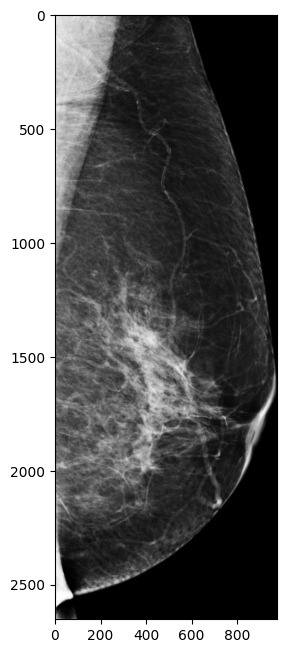

In [13]:
from detectron2.utils.visualizer import ColorMode

# checking that training works (careful, not valid results are the training set!)

dataset_dicts = get_omidb_dicts("/mnt/mia_images/breast/omi-db/iceberg_selection")

#Use the final weights generated after successful training for inference  
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, omidb_model_file)

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.25 #0.8  # set the testing threshold for this model
# Just testing it learnt: passing the train dataset as test!
cfg.DATASETS.TEST = ("omidb_train", )

predictor = DefaultPredictor(cfg)

test_metadata = MetadataCatalog.get("omidb_train")
for d in random.sample(dataset_dicts, 3):    
    print(d["file_name"])
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    print(outputs)
    v = Visualizer(im[:, :, ::-1],
                   metadata=test_metadata, 
                   scale=0.8,
                   instance_mode=ColorMode.IMAGE   
    )
    out = outputs["instances"].to("cpu")
    print(out.pred_classes)
    print(out.pred_boxes)
    print(out.scores)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu")) #Passing the predictions to CPU from the GPU
    plt.imshow(v.get_image()[:, :, ::-1])
    plt.show()
#     cv2_imshow(v.get_image()[:, :, ::-1])

## DBT dataset
No training the model with the DBT dataset

In [14]:
from detectron2.structures import BoxMode

import omidb

import pandas as pd
import io

def get_DBT_dicts(img_dir):
    csv_file = os.path.join(img_dir, "../train_bboxes.csv")
    df = pd.read_csv(csv_file,names=['Patient', 'Study', 'filename', 'side', 'bbox',  'slice', 'bbox_roi'])
    
    dataset_dicts = []
    
    for idx, row in df.iterrows():
        record = {}
        
        filename = os.path.join(img_dir, row["filename"])
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
        
        bbox_roi = row["bbox_roi"][12:-1]
        coords = bbox_roi.split(',')
        r= np.array([0,0,0,0])
        idx = 0
        for c in coords:
            aux = c.split('=')
            r[idx]=(int(aux[1]))
            idx +=1
        bbox_roi = omidb.mark.BoundingBox(r[0],r[1],r[2],r[3])    
        px = [bbox_roi.x1, bbox_roi.x2, bbox_roi.x2, bbox_roi.x1]
        py = [bbox_roi.y1, bbox_roi.y1, bbox_roi.y2, bbox_roi.y2]
        poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
        poly = [p for x in poly for p in x]
        objs = []
        obj =  {
                "bbox": [bbox_roi.x1 , bbox_roi.y1, bbox_roi.x2, bbox_roi.y2],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
            }
        objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

DatasetCatalog.register("DBT_train", lambda: get_DBT_dicts("/home/robert/data/DBT/train"))
MetadataCatalog.get("DBT_train").set(thing_classes=["lesion"])
dbt_metadata = MetadataCatalog.get("DBT_train")


/home/robert/data/DBT/train/DBT-P04901_DBT-S05032_rcc_35.png


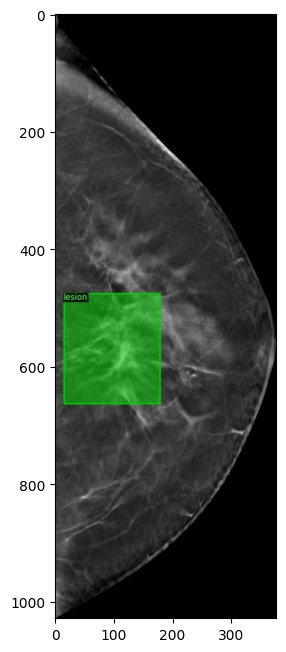

/home/robert/data/DBT/train/DBT-P02798_DBT-S01770_lcc_50.png


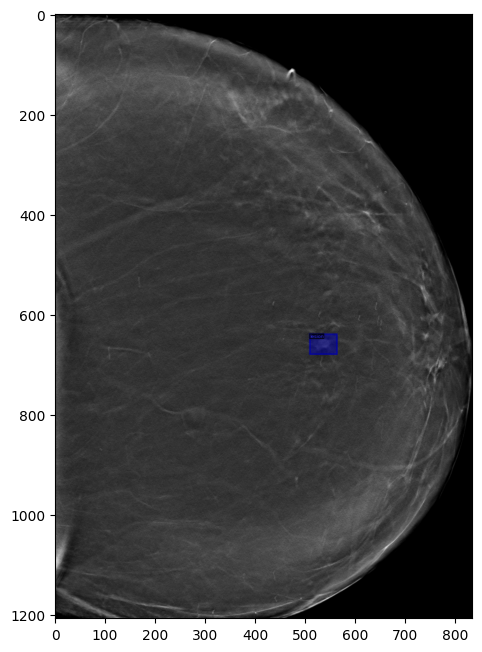

/home/robert/data/DBT/train/DBT-P02493_DBT-S03027_lmlo_39.png


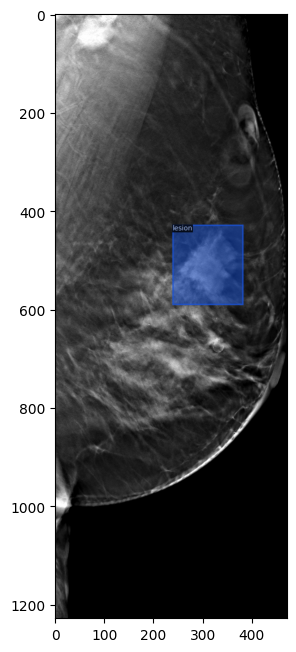

In [15]:
# checking image loading of DBT works ok
dataset_dicts = get_DBT_dicts("/home/robert/data/DBT/train")

for d in random.sample(dataset_dicts, 3):
    print (d["file_name"])
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=dbt_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()

In [16]:
from detectron2.engine import DefaultTrainer

cfg.DATASETS.TRAIN = ("DBT_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
# loading trained weights from omidb
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, omidb_model_file)
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 3000 # was 5000   # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class 

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

# Save config to file
with open("output/"+config_file, "w") as f:
    f.write(cfg.dump())

[01/20 03:29:17 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Sequential(
          (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): FrozenBatchNorm2d(num_features=32, eps=1e-05)
          (2):

[01/20 03:29:22 d2.data.build]: Removed 0 images with no usable annotations. 224 images left.
[01/20 03:29:22 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   lesion   | 224          |
|            |              |
[01/20 03:29:22 d2.data.common]: Serializing 224 elements to byte tensors and concatenating them all ...
[01/20 03:29:22 d2.data.common]: Serialized dataset takes 0.13 MiB
[01/20 03:29:22 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[01/20 03:29:22 d2.data.build]: Using training sampler TrainingSampler
[01/20 03:29:23 d2.engine.train_loop]: Starting training from iteration 0
[01/20 03:29:31 d2.utils.events]:  eta: 0:18:29  iter: 19  total_loss: 0.208  loss_cls: 0.089  loss_box_reg: 0.091  loss_rpn_cls: 0.011  loss_rpn_loc: 0.006  time: 0.3662  data_time: 0.0171 

[01/20 03:33:33 d2.utils.events]:  eta: 0:14:28  iter: 659  total_loss: 0.206  loss_cls: 0.089  loss_box_reg: 0.104  loss_rpn_cls: 0.005  loss_rpn_loc: 0.007  time: 0.3696  data_time: 0.0038  lr: 0.000165  max_mem: 5101M
[01/20 03:33:40 d2.utils.events]:  eta: 0:14:21  iter: 679  total_loss: 0.201  loss_cls: 0.089  loss_box_reg: 0.097  loss_rpn_cls: 0.005  loss_rpn_loc: 0.007  time: 0.3697  data_time: 0.0045  lr: 0.000170  max_mem: 5101M
[01/20 03:33:48 d2.utils.events]:  eta: 0:14:15  iter: 699  total_loss: 0.202  loss_cls: 0.080  loss_box_reg: 0.102  loss_rpn_cls: 0.005  loss_rpn_loc: 0.006  time: 0.3699  data_time: 0.0047  lr: 0.000175  max_mem: 5101M
[01/20 03:33:55 d2.utils.events]:  eta: 0:14:07  iter: 719  total_loss: 0.189  loss_cls: 0.073  loss_box_reg: 0.091  loss_rpn_cls: 0.007  loss_rpn_loc: 0.006  time: 0.3696  data_time: 0.0053  lr: 0.000180  max_mem: 5101M
[01/20 03:34:03 d2.utils.events]:  eta: 0:14:00  iter: 739  total_loss: 0.178  loss_cls: 0.073  loss_box_reg: 0.098 

[01/20 03:38:03 d2.utils.events]:  eta: 0:10:04  iter: 1379  total_loss: 0.162  loss_cls: 0.063  loss_box_reg: 0.086  loss_rpn_cls: 0.002  loss_rpn_loc: 0.004  time: 0.3706  data_time: 0.0052  lr: 0.000250  max_mem: 5101M
[01/20 03:38:10 d2.utils.events]:  eta: 0:09:57  iter: 1399  total_loss: 0.155  loss_cls: 0.059  loss_box_reg: 0.087  loss_rpn_cls: 0.002  loss_rpn_loc: 0.007  time: 0.3707  data_time: 0.0050  lr: 0.000250  max_mem: 5101M
[01/20 03:38:18 d2.utils.events]:  eta: 0:09:49  iter: 1419  total_loss: 0.185  loss_cls: 0.071  loss_box_reg: 0.092  loss_rpn_cls: 0.003  loss_rpn_loc: 0.005  time: 0.3707  data_time: 0.0050  lr: 0.000250  max_mem: 5101M
[01/20 03:38:26 d2.utils.events]:  eta: 0:09:41  iter: 1439  total_loss: 0.164  loss_cls: 0.065  loss_box_reg: 0.092  loss_rpn_cls: 0.003  loss_rpn_loc: 0.004  time: 0.3708  data_time: 0.0045  lr: 0.000250  max_mem: 5101M
[01/20 03:38:33 d2.utils.events]:  eta: 0:09:34  iter: 1459  total_loss: 0.190  loss_cls: 0.062  loss_box_reg: 0

[01/20 03:42:32 d2.utils.events]:  eta: 0:05:36  iter: 2099  total_loss: 0.153  loss_cls: 0.059  loss_box_reg: 0.086  loss_rpn_cls: 0.002  loss_rpn_loc: 0.004  time: 0.3706  data_time: 0.0052  lr: 0.000250  max_mem: 5101M
[01/20 03:42:40 d2.utils.events]:  eta: 0:05:29  iter: 2119  total_loss: 0.149  loss_cls: 0.052  loss_box_reg: 0.081  loss_rpn_cls: 0.004  loss_rpn_loc: 0.005  time: 0.3706  data_time: 0.0046  lr: 0.000250  max_mem: 5101M
[01/20 03:42:47 d2.utils.events]:  eta: 0:05:21  iter: 2139  total_loss: 0.139  loss_cls: 0.047  loss_box_reg: 0.086  loss_rpn_cls: 0.001  loss_rpn_loc: 0.005  time: 0.3708  data_time: 0.0048  lr: 0.000250  max_mem: 5101M
[01/20 03:42:55 d2.utils.events]:  eta: 0:05:14  iter: 2159  total_loss: 0.144  loss_cls: 0.052  loss_box_reg: 0.080  loss_rpn_cls: 0.002  loss_rpn_loc: 0.004  time: 0.3707  data_time: 0.0049  lr: 0.000250  max_mem: 5101M
[01/20 03:43:02 d2.utils.events]:  eta: 0:05:06  iter: 2179  total_loss: 0.143  loss_cls: 0.049  loss_box_reg: 0

[01/20 03:47:01 d2.utils.events]:  eta: 0:01:07  iter: 2819  total_loss: 0.122  loss_cls: 0.041  loss_box_reg: 0.074  loss_rpn_cls: 0.002  loss_rpn_loc: 0.004  time: 0.3706  data_time: 0.0049  lr: 0.000250  max_mem: 5101M
[01/20 03:47:09 d2.utils.events]:  eta: 0:01:00  iter: 2839  total_loss: 0.130  loss_cls: 0.045  loss_box_reg: 0.079  loss_rpn_cls: 0.002  loss_rpn_loc: 0.004  time: 0.3706  data_time: 0.0047  lr: 0.000250  max_mem: 5101M
[01/20 03:47:16 d2.utils.events]:  eta: 0:00:52  iter: 2859  total_loss: 0.132  loss_cls: 0.045  loss_box_reg: 0.083  loss_rpn_cls: 0.002  loss_rpn_loc: 0.003  time: 0.3706  data_time: 0.0048  lr: 0.000250  max_mem: 5101M
[01/20 03:47:24 d2.utils.events]:  eta: 0:00:45  iter: 2879  total_loss: 0.141  loss_cls: 0.043  loss_box_reg: 0.081  loss_rpn_cls: 0.001  loss_rpn_loc: 0.003  time: 0.3707  data_time: 0.0049  lr: 0.000250  max_mem: 5101M
[01/20 03:47:32 d2.utils.events]:  eta: 0:00:37  iter: 2899  total_loss: 0.124  loss_cls: 0.043  loss_box_reg: 0

In [21]:
import os
PATH = os.getenv('PATH')
%env PATH=/home/robert/miniconda2/envs/fast2/bin:$PATH
%load_ext tensorboard
%tensorboard --logdir output --host localhost --port 8885



env: PATH=/home/robert/miniconda2/envs/fast2/bin:/home/robert/miniconda2/envs/fast2/bin:/home/robert/miniconda2/envs/fast2/bin:/home/robert/bin:/home/robert/.local/bin:/usr/local/cuda/bin:/home/robert/bin:/home/robert/.local/bin:/home/robert/miniconda2/bin:/home/robert/miniconda2/condabin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 8885 (pid 37385), started 3 days, 6:45:56 ago. (Use '!kill 37385' to kill it.)

In [18]:
# saving dbt model
import os
os.rename(r'./output/model_final.pth',r'./output/'+dbt_model_file)


### Individual prediction


/home/robert/data/DBT/train/DBT-P01817_DBT-S01841_lcc_20.png
{'instances': Instances(num_instances=1, image_height=2149, image_width=1607, fields=[pred_boxes: Boxes(tensor([[ 527.4869, 1747.8988,  953.6497, 2069.2236]], device='cuda:0')), scores: tensor([0.9036], device='cuda:0'), pred_classes: tensor([0], device='cuda:0')])}
tensor([0])
Boxes(tensor([[ 527.4869, 1747.8988,  953.6497, 2069.2236]]))
tensor([0.9036])


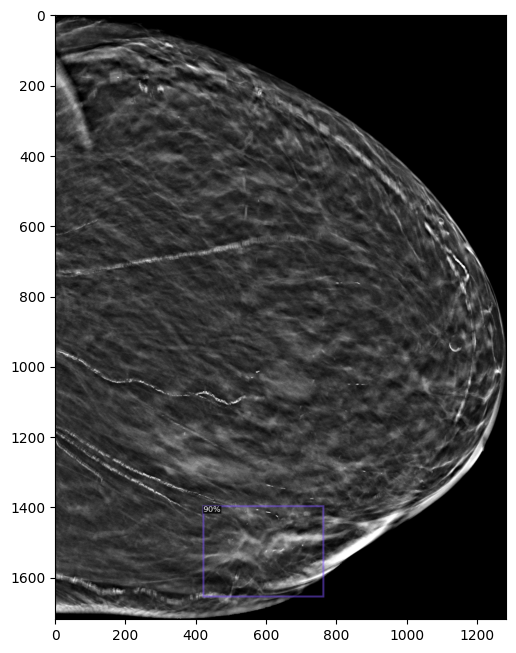

/home/robert/data/DBT/train/DBT-P01839_DBT-S03748_lmlo_12.png
{'instances': Instances(num_instances=2, image_height=2389, image_width=1687, fields=[pred_boxes: Boxes(tensor([[1304.2335, 1654.6685, 1649.4924, 2113.6990],
        [  14.3772,   74.1796,  304.2050,  369.2799]], device='cuda:0')), scores: tensor([0.9785, 0.3163], device='cuda:0'), pred_classes: tensor([0, 0], device='cuda:0')])}
tensor([0, 0])
Boxes(tensor([[1304.2335, 1654.6685, 1649.4924, 2113.6990],
        [  14.3772,   74.1796,  304.2050,  369.2799]]))
tensor([0.9785, 0.3163])


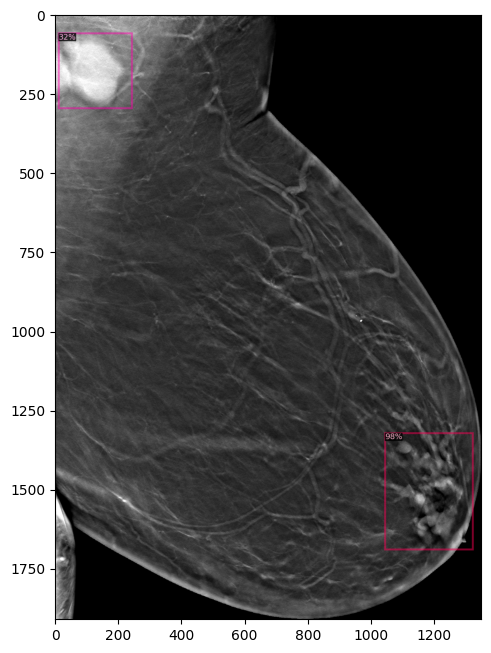

/home/robert/data/DBT/train/DBT-P02171_DBT-S04537_rmlo_29.png
{'instances': Instances(num_instances=1, image_height=2457, image_width=988, fields=[pred_boxes: Boxes(tensor([[ 411.4106, 1255.3276,  777.7894, 1627.1627]], device='cuda:0')), scores: tensor([0.9905], device='cuda:0'), pred_classes: tensor([0], device='cuda:0')])}
tensor([0])
Boxes(tensor([[ 411.4106, 1255.3276,  777.7894, 1627.1627]]))
tensor([0.9905])


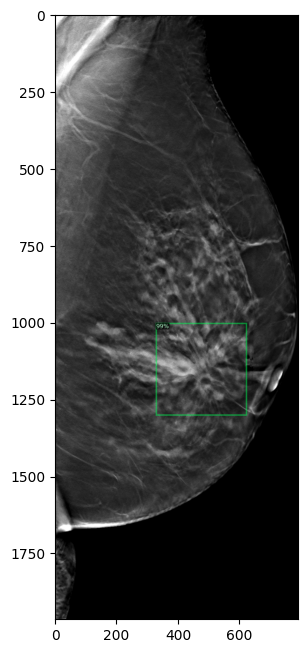

In [19]:
from detectron2.utils.visualizer import ColorMode

#Use the final weights generated after successful training for inference  
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, dbt_model_file)

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1 #0.8  # set the testing threshold for this model
#Again checking only with train dataset! 
cfg.DATASETS.TEST = ("DBT_train", )

predictor = DefaultPredictor(cfg)

test_metadata = MetadataCatalog.get("DBT_train")
for d in random.sample(dataset_dicts, 3):    
    print(d["file_name"])
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    print(outputs)
    v = Visualizer(im[:, :, ::-1],
                   metadata=test_metadata, 
                   scale=0.8,
                   instance_mode=ColorMode.IMAGE   
    )
    out = outputs["instances"].to("cpu")
    print(out.pred_classes)
    print(out.pred_boxes)
    print(out.scores)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu")) #Passing the predictions to CPU from the GPU
    plt.imshow(v.get_image()[:, :, ::-1])
    plt.show()
#     cv2_imshow(v.get_image()[:, :, ::-1])